# Recommendation System for Netflix Movies - Ryan Gomberg
## May 18, 2025
*This is a technical assessment for the Data Science and Engineering Intern position at Stack Sports.*

The Dataset can be found through the website: https://www.kaggle.com/datasets/satpreetmakhija/netflix-movies-and-tv-shows-2021/data

This file will eventually be accessible through my GitHub: https://github.com/ryangomberg?tab=repositories

## Introduction to the Dataset, Goals

-   We are using the netflix_db.csv and netflix_description.csv datasets from Kaggle
-   In total, there are 5967 unique entries, 5897 unique movies, and 14 different features
-   While this is not an exhaustive list, some features are
    -   Description: offers a text description of each movie.
    -   Genres: provides 1-3 categories for each movie.
    -   Rating: the movie’s IMDb rating.
    -   Other miscellaneous features: Cast, Production Country, Release Date, Duration
-   The general goals of this project are to:
    -   Apply exploratory data analysis to identify and distributions and conclusions.
    -   Use cosine similarity to recommend the top 3 movies based on movie description.
    -   Build a recurrent neural network to recommend the top 3 movies based on movie history.

## Preprocessing
The following implementations were made to the original dataset to prepare ourselves for exploratory data analysis and deploying our recommendation system models.

1.  Merged netflix_db and netflix_description to a single dataset.
2.  Rewrite IMDb scores as floats and fill missing values with the average score.
3.  Drop missing values in the ‘Title’ and ‘Date Added’ columns.
4.  Sort titles chronologically in the ‘Date Added’ column (done in RNN Model).

In [37]:
import os
import sys
import subprocess

import warnings
warnings.filterwarnings("ignore")

subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"],
                      stdout=subprocess.DEVNULL,
                      stderr=subprocess.DEVNULL)
                      
subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"],
                      stdout=subprocess.DEVNULL,
                      stderr=subprocess.DEVNULL)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import torch 
import torch.nn as nn
import tensorflow as tf

n = pd.read_csv('netflix_db.csv')
ndes = pd.read_csv('netflix_description.csv')
df = n.merge(ndes)

df = df.reset_index(drop=True)  

# Rewriting IMDb Scores as floats
def score_to_float(x):
    if x == '10.0/10':
        return 10.0
    else:
        return(float(str(x)[0:3]))
    
df['Imdb Score'] = df['Imdb Score'].apply(score_to_float)

# Set missing values to the mean score
df['Imdb Score'] = df['Imdb Score'].fillna(df['Imdb Score'].mean()) 

## Exploratory Data Analysis
We will explore 3 graphs within our aggregated data. The first of which is the distribution of IMDb ratings. The submodules seaborn and matplotlib were used for visualization.


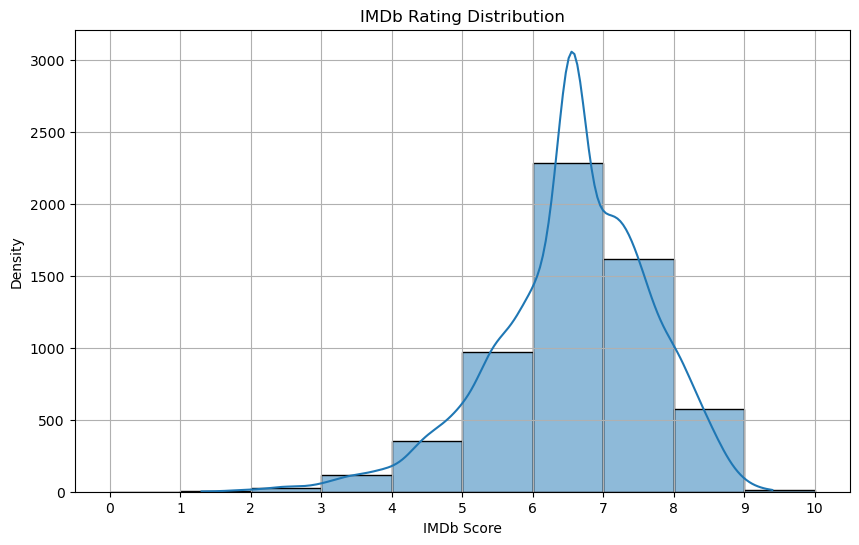

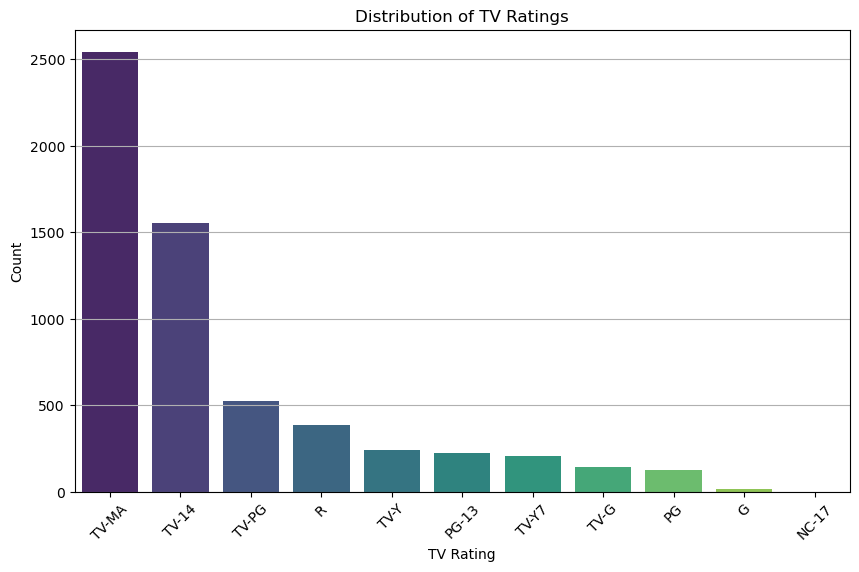

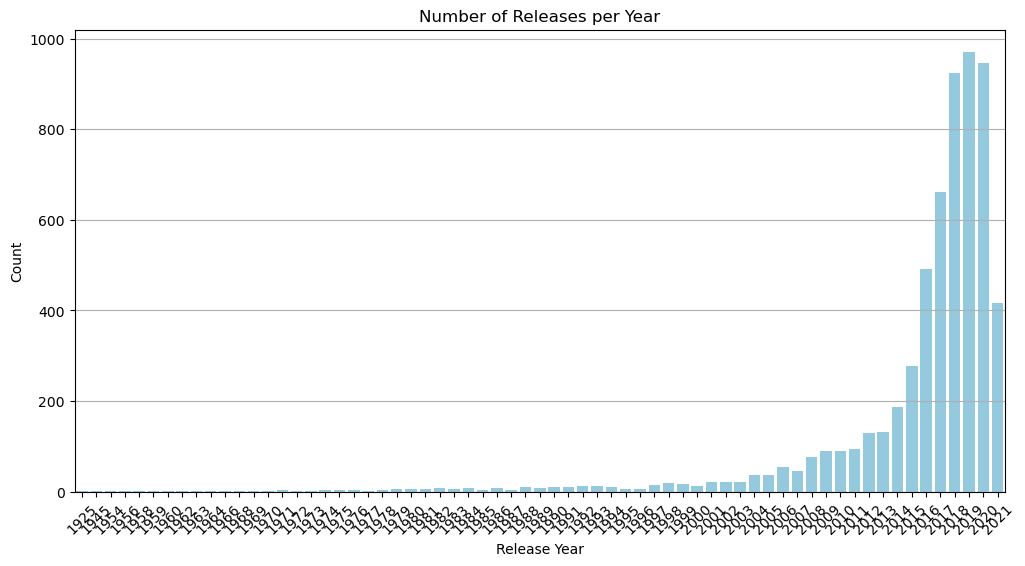

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# IMDb Score Distribution
bins = np.arange(0, 11, 1)
df['Rating Bin'] = pd.cut(df['Imdb Score'], bins=bins, right=False)
rating_counts = df['Rating'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(df['Imdb Score'], bins=bins, kde=True, edgecolor='black')

plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.xticks(bins)
plt.grid(True)
plt.show()

# Rating counts
plt.figure(figsize=(10,6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.title("Distribution of TV Ratings")
plt.xlabel("TV Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Release year counts
df['Release Date'] = pd.to_numeric(df['Release Date'], errors='coerce')
year_counts = df['Release Date'].dropna().astype(int).value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(x=year_counts.index, y=year_counts.values, color='skyblue')
plt.title("Number of Releases per Year")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### IMDb Ratings
The majority of IMDb ratings fall within 4-9, with 
-  6-7 taking up roughly 30% of our data.
-  5-8 taking up roughly 85% of our data.
-  Ratings of 0-3 and 9-10 being exceptionally rare.

This reflects the standards of most IMDB ratings, with 7/10 as the “most average” score.

### Distribution of TV Ratings
-  Almost half of the movies are rated for mature audiences only.
-  Roughly 4300 movies have an age restriction of 13+.
-  It is likely that this dataset is not tailored towards family/children’s films (i.e. animated films).

### Number of Releases per Year
-  As expected, almost all films are released after 1995, with roughly 80% of them released after 2014.
-  Almost half of the movies in this dataset were released between 2018-2020.

## Model 1: Cosine Similarity
Given two vectors, $\overrightarrow{A}$, $\overrightarrow{B}$, the similarity between them is given by the cosine of the angle separating them
$$\cos \theta = \frac{\overrightarrow{A} \cdot \overrightarrow{B}}{||\overrightarrow{A}||||\overrightarrow{B}||}.$$
Since $-1 \leq \cos \theta \leq 1$, similarity is measured by -1 to 1, where 1 indictes a perfect correlation and 0 indicates no correlation. This is one way of implementing recommendation systems: given a piece of data $\overrightarrow{A}$, compute the cosine similarity between candidate data entries $\overrightarrow{B}$ and output the three that are closest to 1. 

In context of our dataset, we will use cosine similarity based on the following factor:
-  Content-based filtering: Given a movie description, output the top 3 movie recommendations whose description closely matches the inputted one.

We will use our newfound recommendation system to find 3 movies whose description is most similar to *Zoo*.

In [34]:
# TF-IDF Vectorization of Descriptions
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_matrix = tfidf.fit_transform(df['Description'])

# Compute cosine similarity matrix of Descriptions
cos_sim = cosine_similarity(tfidf_matrix)

# Recommendation function - input title of movie in dataset
# and outputs top 3 movies based on the given cos_sim matrix
def recommend_cosine_description(title, top_k = 3):
    # Find the index of the movie with the given title
    idx = df[df['Title'] == title].index
    if len(idx) == 0:
        return f"Title '{title}' not found."
    idx = idx[0]
    
    # Looking out for indexing errors
    if idx >= len(cos_sim):
        return f"Index {idx} is out of bounds for similarity matrix of size {len(cos_sim)}"

    # Rank movies by similarity
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Pick top 3 movies (excluding itself)
    top_indices = [i for i, _ in sim_scores[1:top_k+1]]
    return df.iloc[top_indices][['Title', 'Genres', 'Imdb Score']]

print("Cosine recommendations:")
print(recommend_cosine_description("Zoo"))

Cosine recommendations:
                       Title  \
592           Being Napoleon   
1806           Ghosts of War   
1472  El señor de los Cielos   

                                                                 Genres  \
592                                                       Documentaries   
1806                                                      Horror Movies   
1472  Crime TV Shows, International TV Shows, Spanish-Language TV Shows   

      Imdb Score  
592          5.5  
1806         5.4  
1472         6.9  


In [35]:
print(df[df['Title'] == 'Being Napoleon']['Description'])
print(df[df['Title'] == 'Ghosts of War']['Description'])
print(df[df['Title'] == 'El señor de los Cielos']['Description'])

592    On the 200th anniversary of the Battle of Waterloo, thousands of enthusiasts reenact the epic clash. But there can only be one Napoleon.
Name: Description, dtype: object
1806    Five, battle-worn Allied soldiers guarding a chateau previously occupied by Nazis start experiencing unexplained and terrifying supernatural horrors.
Name: Description, dtype: object
1472    Only Aurelio Casillas can fill Pablo Escobar's shoes and become Mexico's biggest drug trafficker of the '90s.
Name: Description, dtype: object


Overall, it appears that the recommendation system is partially successful.
-   The movie *El señor de los Cielos* is very similar to *Zoo*, mainly thematically and with respect to the plot.
-   *Ghosts of War* can be acquainted with *Zoo* in the sense of psychological trauma.
-   *Being Napoleon* is entirely unrelated with *Zoo*, but might have been recommended as a false positive due to some syntax overlap (i.e. battle, clash).

## Model 2: Recurrent Neural Networks (RNNs)
Recurrent neural networks are neural networks well-suited for sequential data, storing data from previous time-steps and learning from temporal patterns.

The structure is almost identical to a typical neural network, with the exception of a recurrent weight **$U$**, repeating activation functions while using the same weights and biases $W$, $B$ (over multiple time steps) in each hidden layer.

Additionally, we choose the number of epochs, or number of iterations of forward-feeding and backpropagation, to balance computational cost while minimizing our loss function. 

For out dataset, RNNs are appropriate if we select a “history” of movies the user has watched. Through this, the neural network will output 3 movies to recommend with these optimized weights and biases.

We propose the following RNN structure:
-   **Input Layer**: 5 neurons, or the last 5 movies the user has watched
-   **Embedding Layer**: 32 neurons, mapping categorical data into a vector of 32 integers.
-   **Hidden Layer**: 64 neurons, GRU (Gated Recurrent Unit). Uses *sigmoid* and *tanh* activation functions as transitions – namely to avoid the vanishing gradient problem during backpropagation
-   **Output Layer**: 3 neurons, uses softmax (logits) as the activation function, predicting the 3 most likely movie to recommend
-   Since we are dealing with a multi-classification problem, we impose a *cross-entropy loss function*
-   We run over 5 sequences (as implied by input layer) and 30 epochs to achieve a desirable, minimal loss function

Relevant submodules: LabelEncoder, torch, nn, TensorFlow, defaultdict 

In [ ]:
# RNN-Based Recommender
# Drop missing rows and sort titles chronologically
from collections import defaultdict
df2 = df.dropna(subset=['Title', 'Date Added'])
df2['Date Added'] = pd.to_datetime(df2['Date Added'])
df2 = df2.sort_values(['Title', 'Date Added'])

# Set 5 sequences for the RNN model
user_sequences = defaultdict(list)
for i, row in df2.iterrows():
    user_sequences[row['Production Country']].append(row['Title'])

sequences = [seq for seq in user_sequences.values() if len(seq) >= 5]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_titles = [title for seq in sequences for title in seq]
le.fit(all_titles)

inputs, targets = [], []
seq_len = 5

for seq in sequences:
    seq = le.transform(seq)
    for i in range(1, len(seq)):
        prev = seq[max(0, i - seq_len):i]
        prev = [0] * (seq_len - len(prev)) + list(prev)
        inputs.append(prev)
        targets.append(seq[i])

inputs = torch.tensor(inputs, dtype=torch.long) 
targets = torch.tensor(targets, dtype=torch.long)

# Neural Network Architecture: Size of layers
vocab_size = len(le.classes_)
embed_dim = 32
hidden_dim = 64

# Neural Network Architecture: Defining Activation Functions
embedding = nn.Embedding(vocab_size, embed_dim)
rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
fc = nn.Linear(hidden_dim, vocab_size)

# Training Setup
params = list(embedding.parameters()) + list(rnn.parameters()) + list(fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training model over 30 epochs
for epoch in range(30):
    optimizer.zero_grad()
    x_embed = embedding(inputs)
    _, h = rnn(x_embed)
    logits = fc(h.squeeze(0))
    loss = loss_fn(logits, targets)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Use the finalized model to output top 3 movie recommendations
def recommend_rnn(history_titles, top_k=3):
    history_enc = le.transform([t for t in history_titles if t in le.classes_])
    history_enc = [0] * (seq_len - len(history_enc)) + list(history_enc)[-seq_len:]
    x = torch.tensor([history_enc])
    
    with torch.no_grad():
        x_embed = embedding(x)
        _, h = rnn(x_embed)
        logits = fc(h.squeeze(0))
        top = torch.topk(logits, top_k).indices
        recommended_titles = le.inverse_transform(top.numpy().flatten())
    
    # Get genres and imdb scores from DataFrame
    results = df[df['Title'].isin(recommended_titles)][['Title', 'Genres', 'Imdb Score']]
    return results.drop_duplicates(subset='Title').reset_index(drop=True)

For simplicity, we select our viewing history as the first 5 movies in the dataset.

In [39]:
print("History: ['(Un)Well', '#Alive', '#AnneFrank - Parallel Stories', '#blackAF', '#cats_the_mewvie']")
print(recommend_rnn(['(Un)Well', '#Alive', '#AnneFrank - Parallel Stories', '#blackAF', '#cats_the_mewvie']))

History: ['(Un)Well', '#Alive', '#AnneFrank - Parallel Stories', '#blackAF', '#cats_the_mewvie']
                        Title  \
0         48 Christmas Wishes   
1  March Comes in Like a Lion   
2                      Naruto   

                                                Genres  Imdb Score  
0                   Children & Family Movies, Comedies         3.8  
1  Anime Series, International TV Shows, Teen TV Shows         8.4  
2                 Anime Series, International TV Shows         8.3  


-  As expected, the loss function starts off large over the first few iterations of the neural network.
-  As we repeatedly run through and backpropagate, the loss function appears to be readily converging to some minimum.
-  The viewing history primarily falls into international movies, documentaries, and comedies.
-  The recommended movies share some of the genres in our viewing history. While we did not empirically measure the accuracy of our model, we can say there is some success in recommending new movies.

## Conclusion
Throughout this project, we have
-  *Motivated* the need for recommendation systems.
-  Introduced the dataset and necessary *preprocessing* techniques.
-  Performed *exploratory data analysis* on different features in our data.
-  Used *cosine similarity* to recommend movies with similar descriptions.
-  Deployed a *recurring neural network* to recommend movies given a user’s viewing history (retrospective technique).

If time allowed, I would have liked to
-  Learn more about the general dataset through visualization techniques
-  Explore ways to improve the *cosine similarity* recommendation system (i.e. advanced word embeddings such as Word2Vec).
-  Apply *cosine similarity* based on different features in the dataset (i.e. Rating, Genres).
-  Find ways to test accuracy in our *recurrent neural network* and do more tinkering with the hidden/output layers.